# **DermaGPT**

In [1]:
#%pip install datasets --quiet
#%pip install python-dotenv --quiet
#%pip install sentence-transformers --quiet
#%pip install pinecone-client --quiet
#%pip install pinecone --quiet
#%pip install -U langchain langchain-openai
#%pip install wordcloud --quiet

## **API Usage**

### **Observe Raw API Response**

In [2]:
import requests
import json
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Select the first image only
photo_url = "https://images.pexels.com/photos/614810/pexels-photo-614810.jpeg"
api_url = os.getenv("FACE_ANALYSIS_API_URL")

payload = {"data": {"photo_url": photo_url}}

try:
    response = requests.post(api_url, json=payload)
    result = response.json()

    print(f"\n📸 Image: {photo_url}")
    print("📦 Raw API Output:")
    print(json.dumps(result, indent=2))

except Exception as e:
    print("❌ Error while fetching raw output")
    print(f"Status Code: {response.status_code}")
    print(response.text)


📸 Image: https://images.pexels.com/photos/614810/pexels-photo-614810.jpeg
📦 Raw API Output:
{
  "message": "Your Wrinkle is Gotten Successfully",
  "acne": [
    {
      "region": "Frontal",
      "level": "None"
    },
    {
      "region": "Eye",
      "level": "None"
    },
    {
      "region": "Nose",
      "level": "None"
    },
    {
      "region": "Lips",
      "level": "None"
    },
    {
      "region": "Leftcheeks",
      "level": "None"
    },
    {
      "region": "Rightcheeks",
      "level": "1"
    }
  ],
  "wrinkle": [
    {
      "region": "Frontal",
      "level": "2"
    },
    {
      "region": "Eye",
      "level": "None"
    },
    {
      "region": "Nose",
      "level": "None"
    },
    {
      "region": "Lips",
      "level": "None"
    },
    {
      "region": "Leftcheeks",
      "level": "1"
    },
    {
      "region": "Rightcheeks",
      "level": "1"
    }
  ]
}


### **Observing Several API Responses**

In [3]:
import requests
import time

photo_urls = [
    "https://images.pexels.com/photos/614810/pexels-photo-614810.jpeg",
    "https://images.pexels.com/photos/415829/pexels-photo-415829.jpeg",
    "https://images.pexels.com/photos/2598024/pexels-photo-2598024.jpeg",
    "https://images.pexels.com/photos/35065/homeless-man-color-poverty.jpg",
    "https://images.pexels.com/photos/2380794/pexels-photo-2380794.jpeg",
    "https://images.pexels.com/photos/2709388/pexels-photo-2709388.jpeg"
]

api_url = os.getenv("FACE_ANALYSIS_API_URL")

results = []  # Store all API results here

for i, photo_url in enumerate(photo_urls, start=1):
    print(f"\n📸 Image {i}: {photo_url}")

    payload = {"data": {"photo_url": photo_url}}

    try:
        response = requests.post(api_url, json=payload)
        result = response.json()

        # Build summary for logging
        wrinkle_summary = ", ".join(
            [f"{r['region']}:{r['level']}" for r in result.get("wrinkle", [])]
        )
        acne_summary = ", ".join(
            [f"{r['region']}:{r['level']}" for r in result.get("acne", [])]
        )

        print("🧠 Summary:")
        print(f"  Wrinkle → {wrinkle_summary}")
        print(f"  Acne    → {acne_summary}")

        # Add structured result to the list
        results.append({
            "image": photo_url,
            "wrinkle": result.get("wrinkle", []),
            "acne": result.get("acne", [])
        })

    except Exception as e:
        print(f"❌ Error for Image {i}: {e}")
        print(f"Status Code: {response.status_code}")
        print(response.text)

    time.sleep(1)


📸 Image 1: https://images.pexels.com/photos/614810/pexels-photo-614810.jpeg
🧠 Summary:
  Wrinkle → Frontal:2, Eye:None, Nose:None, Lips:None, Leftcheeks:1, Rightcheeks:1
  Acne    → Frontal:None, Eye:None, Nose:None, Lips:None, Leftcheeks:None, Rightcheeks:1

📸 Image 2: https://images.pexels.com/photos/415829/pexels-photo-415829.jpeg
🧠 Summary:
  Wrinkle → Frontal:None, Eye:None, Nose:None, Lips:None, Leftcheeks:None, Rightcheeks:None
  Acne    → Frontal:None, Eye:None, Nose:None, Lips:None, Leftcheeks:None, Rightcheeks:None

📸 Image 3: https://images.pexels.com/photos/2598024/pexels-photo-2598024.jpeg
🧠 Summary:
  Wrinkle → Frontal:1, Eye:None, Nose:None, Lips:1, Leftcheeks:2, Rightcheeks:2
  Acne    → Frontal:None, Eye:None, Nose:None, Lips:None, Leftcheeks:None, Rightcheeks:None

📸 Image 4: https://images.pexels.com/photos/35065/homeless-man-color-poverty.jpg
🧠 Summary:
  Wrinkle → Frontal:2, Eye:1, Nose:None, Lips:None, Leftcheeks:1, Rightcheeks:1
  Acne    → Frontal:None, Eye:Non

### **API Response Breakdown**

The face analysis API returns localized wrinkle and acne severity levels for 6 facial regions:

- Frontal
- Eye
- Nose
- Lips
- Leftcheeks
- Rightcheeks

Each `"level"` field represents the detected severity in that region:

- `"None"` → No visible wrinkle or acne
- `"1"` → Mild presence
- `"2"` → Noticeable/moderate presence

> ⚠️ Based on observed responses, `"2"` appears to be the current maximum level returned by the API. Levels `"3"` to `"5"` have not been observed and may not be supported.

### **Scoring Strategy**

The wrinkle and acne analysis API returns separate `"level"` values for each facial region (e.g., Frontal, Eye, Lips). To simplify this into a single score that can be embedded into the RAG prompt, I decided to apply the following normalization strategy:

1. Convert `"None"` to `0` (meaning no visible issue)
2. Parse string numbers like `"1"` and `"2"` as integers  
   > ⚠️ Levels `"3"` to `"5"` have not been observed in practice and are excluded
3. Ignore invalid or missing entries
4. Calculate the average across all facial regions
5. Round to two decimal places

This produces a float score (e.g., `0.33` and `1.67`) that reflects the overall severity of wrinkles or acne, and can be further interpreted using qualitative labels like Low / Moderate.

In [4]:
# Function to calculate average level score across facial regions
def average_score(regions):
    level_map = {"None": 0, "1": 1, "2": 2}  # Max level observed = 2
    values = [level_map.get(r["level"], 0) for r in regions if r["level"] in level_map]
    return round(sum(values) / len(values), 2) if values else 0

In [5]:
# Loop over results and print average scores
print("\n📊 Average Score Summary:")
for i, entry in enumerate(results, start=1):
    wrinkle_avg = average_score(entry["wrinkle"])
    acne_avg = average_score(entry["acne"])

    print(f"\n📸 Image {i}: {entry['image']}")
    print(f"✅ Average Wrinkle Score: {wrinkle_avg}")
    print(f"✅ Average Acne Score: {acne_avg}")


📊 Average Score Summary:

📸 Image 1: https://images.pexels.com/photos/614810/pexels-photo-614810.jpeg
✅ Average Wrinkle Score: 0.67
✅ Average Acne Score: 0.17

📸 Image 2: https://images.pexels.com/photos/415829/pexels-photo-415829.jpeg
✅ Average Wrinkle Score: 0.0
✅ Average Acne Score: 0.0

📸 Image 3: https://images.pexels.com/photos/2598024/pexels-photo-2598024.jpeg
✅ Average Wrinkle Score: 1.0
✅ Average Acne Score: 0.0

📸 Image 4: https://images.pexels.com/photos/35065/homeless-man-color-poverty.jpg
✅ Average Wrinkle Score: 0.83
✅ Average Acne Score: 0.17

📸 Image 5: https://images.pexels.com/photos/2380794/pexels-photo-2380794.jpeg
✅ Average Wrinkle Score: 1.33
✅ Average Acne Score: 0.17

📸 Image 6: https://images.pexels.com/photos/2709388/pexels-photo-2709388.jpeg
✅ Average Wrinkle Score: 0.33
✅ Average Acne Score: 1.67


### **Sample User Quiz Answers**

In [11]:
user_quiz = {
    "age": 23,
    "gender": "0",
    "has_botox": "0",
    "skin_type": "0",
    "main_goals": [1, 2],
    "daily_water": 3,
    "sleep_duration": 7,
    "focused_face_area": [4, 5, 6],
    "skin_sensitivities": [1],
    "daily_exercise_duration": 30,
    "daily_exercise_days_per_week": 3
}

### **Converting the Quiz JSON to Natural Language**

While working with large language models like GPT, I noticed that feeding raw JSON data (like the user quiz structure) often leads to vague or generic answers.

To improve both understanding and personalization, I convert the quiz dictionary into a natural language summary (`quiz_text`). This allows the model to interpret user attributes in a more human and contextual way — for example, instead of parsing `"skin_type": 1`, it reads “Their skin type is Oily.”

I also include image analysis scores like average wrinkle and acne levels. Since these scores are numeric (e.g., 0.67), I map them to qualitative levels (e.g., Low, Moderate) and clarify the scoring range. Based on my API testing, the scale ranges from `"None"` (0) to `"2"` (Moderate), as higher values like `"3"`–`"5"` have not been observed.

This small transformation significantly improves the clarity and relevance of the generated skincare advice.

In [16]:
def convert_quiz_to_text(
    quiz_data: dict,
    wrinkle_data: list,
    acne_data: list,
    wrinkle_score: float,
    acne_score: float
) -> str:
    # Mappings
    skin_type_map = {0: "Normal", 1: "Oily", 2: "Dry", 3: "Combination"}
    goals_map = {
        1: "hydration",
        2: "wrinkle prevention",
        3: "acne care",
        4: "brightening"
    }
    areas_map = {
        1: "Frontal",
        2: "Eye",
        3: "Nose",
        4: "Lips",
        5: "Leftcheeks",
        6: "Rightcheeks"
    }
    sensitivities_map = {
        0: "Fragrance",
        1: "Alcohol",
        2: "Parabens",
        3: "Sulfates"
    }
    gender_pronoun = {
        "0": ("he", "his"),
        "1": ("she", "her"),
        "2": ("they", "their"),
    }

    def interpret_score(score):
        try:
            score = float(score)
        except (TypeError, ValueError):
            return "None"
        if score == 0:
            return "None"
        elif score < 1.5:
            return "Low"
        else:
            return "Moderate"

    def get_level(region_list, region_name):
        for region in region_list:
            if region["region"] == region_name:
                return interpret_score(region["level"])
        return "None"

    def pluralize(value, unit):
        return f"{value} {unit}" + ("" if value == 1 else "s")

    wrinkle_level = interpret_score(wrinkle_score)
    acne_level = interpret_score(acne_score)
    pronoun, possessive = gender_pronoun.get(str(quiz_data.get("gender", "3")), ("they", "their"))

    # Focused area summary
    focused_details = []
    for area_id in quiz_data['focused_face_area']:
        name = areas_map.get(area_id, "unknown")
        wrinkle = get_level(wrinkle_data, name)
        acne = get_level(acne_data, name)
        focused_details.append(f"{name} (wrinkle: {wrinkle}, acne: {acne})")
    focused_summary = ', '.join(focused_details)

    # Skin sensitivities summary (optional)
    sensitivities_list = quiz_data.get("skin_sensitivities", [])
    if sensitivities_list:
        sensitivity_desc = f"\n{pronoun.capitalize()} has sensitivities to: " + ", ".join(
            [sensitivities_map.get(s, "unknown") for s in sensitivities_list]) + "."
    else:
        sensitivity_desc = ""

    return f"""{pronoun.capitalize()} is {quiz_data['age']} years old and has {'had botox' if quiz_data['has_botox'] == '1' else 'not had botox'}.
{possessive.capitalize()} skin type is {skin_type_map.get(int(quiz_data['skin_type']), 'unknown')}.
{possessive.capitalize()} main skincare goals are: {', '.join([goals_map.get(g, 'unknown') for g in quiz_data['main_goals']])}.
{pronoun.capitalize()} drinks {quiz_data['daily_water']} cups of water daily and sleeps around {pluralize(quiz_data['sleep_duration'], 'hour')} per night.
{pronoun.capitalize()} exercises {pluralize(quiz_data['daily_exercise_duration'], 'minute')} per day, {pluralize(quiz_data['daily_exercise_days_per_week'], 'day')} per week.
Based on image analysis, {possessive} wrinkle level is {wrinkle_level} ({wrinkle_score:.2f}) and acne level is {acne_level} ({acne_score:.2f}), on a 3-point scale.
{possessive.capitalize()} focused facial regions include: {focused_summary}.{sensitivity_desc}
"""

In [17]:
result = results[0]

quiz_text = convert_quiz_to_text(user_quiz, result["wrinkle"], result["acne"], wrinkle_avg, acne_avg)

In [18]:
print(quiz_text)

He is 23 years old and has not had botox.
His skin type is Normal.
His main skincare goals are: hydration, wrinkle prevention.
He drinks 3 cups of water daily and sleeps around 7 hours per night.
He exercises 30 minutes per day, 3 days per week.
Based on image analysis, his wrinkle level is Low (0.33) and acne level is Moderate (1.67), on a 3-point scale.
His focused facial regions include: Lips (wrinkle: None, acne: None), Leftcheeks (wrinkle: Low, acne: None), Rightcheeks (wrinkle: Low, acne: Low).
He has sensitivities to: Alcohol.



## **Collecting QA Pairs**

### **🧠 Pinecone Vector Upload**

This script embeds dermatology QA pairs and uploads them to a Pinecone index (`dermagpt-safe`).

Vectors are uploaded in small batches (default: 50) to:
- Avoid API timeouts or memory issues
- Improve upload stability and tracking
- Allow retrying only failed parts if needed

Each vector includes:
- `id`: Unique QA identifier
- `values`: 384-dim question embedding
- `metadata`: Original question + answer

Edit `num_questions` to control how many QA pairs are uploaded.

In [ ]:
import os
import time
from dotenv import load_dotenv
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from pinecone import Pinecone, ServerlessSpec

# === Config ===
index_name = "dermagpt-safe"
namespace = "default"
embedding_dim = 384
num_questions = None  # Tweak here to change the number of QA pairs to upload (None: all of them)

# === Load API Key from .env ===
load_dotenv()
api_key = os.getenv("PINECONE_API_KEY")
if not api_key:
    raise RuntimeError("❌ PINECONE_API_KEY not found in .env file")

# === Load Dataset ===
dataset = load_dataset("Mreeb/Dermatology-Question-Answer-Dataset-For-Fine-Tuning")
raw_pairs = dataset["train"]

qa_pairs = [
    {
        "id": f"qa_{i}",
        "question": item["prompt"].strip(),
        "answer": item["response"].strip()
    }
    for i, item in enumerate(raw_pairs)
    if item["prompt"] and item["response"]
]
if num_questions:
    qa_pairs = qa_pairs[:num_questions]

print(f"✅ Selected {len(qa_pairs)} question-answer pairs")

# === Embed Questions ===
model = SentenceTransformer("all-MiniLM-L6-v2")
questions = [qa["question"] for qa in qa_pairs]
embeddings = model.encode(questions, convert_to_tensor=False)
print(f"✅ Embedded {len(embeddings)} questions")

# === Connect to Pinecone ===
pc = Pinecone(api_key=api_key)

if index_name in pc.list_indexes().names():
    print(f"🧨 Deleting existing index: {index_name}")
    pc.delete_index(index_name)
    time.sleep(2)

print("📦 Creating Pinecone index...")
pc.create_index(
    name=index_name,
    dimension=embedding_dim,
    metric="cosine",
    spec=ServerlessSpec(cloud="aws", region="us-east-1")
)

# === Wait for Index to Be Ready ===
print("⏳ Waiting for index readiness...")
index = pc.Index(index_name)
ready = False
for _ in range(60):
    try:
        stats = index.describe_index_stats()
        if stats:
            print("✅ Index is ready")
            ready = True
            break
    except Exception as e:
        print(f"Waiting... ({e})")
    time.sleep(2)

if not ready:
    raise RuntimeError("❌ Timeout: Index is not ready")

# === Prepare Vectors with Metadata ===
vectors = [
    {
        "id": qa["id"],
        "values": embeddings[i].tolist(),
        "metadata": {
            "question": qa["question"],
            "answer": qa["answer"]
        }
    }
    for i, qa in enumerate(qa_pairs)
]

# === Upload Vectors in Batches ===
batch_size = 50
num_batches = (len(vectors) + batch_size - 1) // batch_size
print(f"📤 Uploading vectors in {num_batches} batches...")

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min(start_idx + batch_size, len(vectors))
    batch = vectors[start_idx:end_idx]

    try:
        index.upsert(vectors=batch, namespace=namespace)
        print(f"  ✅ Batch {i+1}/{num_batches} uploaded ({len(batch)} vectors)")
        time.sleep(1)  # Optional: Small pause between batches
    except Exception as e:
        print(f"  ❌ Error uploading batch {i+1}: {e}")

print(f"✅ Successfully uploaded {len(vectors)} vectors to Pinecone")
print(f"✅ Index name: {index_name}, Namespace: {namespace}")
print("✅ Vector upload complete.")

✅ Selected 1460 question-answer pairs
✅ Embedded 1460 questions
🧨 Deleting existing index: dermagpt-safe
📦 Creating Pinecone index...
⏳ Waiting for index readiness...
✅ Index is ready
📤 Uploading vectors in 30 batches...
  ✅ Batch 1/30 uploaded (50 vectors)
  ✅ Batch 2/30 uploaded (50 vectors)
  ✅ Batch 3/30 uploaded (50 vectors)
  ✅ Batch 4/30 uploaded (50 vectors)
  ✅ Batch 5/30 uploaded (50 vectors)
  ✅ Batch 6/30 uploaded (50 vectors)
  ✅ Batch 7/30 uploaded (50 vectors)
  ✅ Batch 8/30 uploaded (50 vectors)
  ✅ Batch 9/30 uploaded (50 vectors)
  ✅ Batch 10/30 uploaded (50 vectors)
  ✅ Batch 11/30 uploaded (50 vectors)
  ✅ Batch 12/30 uploaded (50 vectors)
  ✅ Batch 13/30 uploaded (50 vectors)
  ✅ Batch 14/30 uploaded (50 vectors)
  ✅ Batch 15/30 uploaded (50 vectors)
  ✅ Batch 16/30 uploaded (50 vectors)
  ✅ Batch 17/30 uploaded (50 vectors)
  ✅ Batch 18/30 uploaded (50 vectors)
  ✅ Batch 19/30 uploaded (50 vectors)
  ✅ Batch 20/30 uploaded (50 vectors)
  ✅ Batch 21/30 uploaded (50

## **Find Related Questions**

In [ ]:
user_question = "What are the best treatments for acne?"

In [ ]:
from sentence_transformers import SentenceTransformer

def get_context_from_query(user_question: str, top_k: int = 3):
    """
    Query Pinecone and return context string + raw matches.
    """
    model = SentenceTransformer("all-MiniLM-L6-v2")
    embedded_question = model.encode(user_question).tolist()

    query_result = index.query(
        vector=embedded_question,
        top_k=top_k,
        include_metadata=True,
        namespace="default"
    )

    context_parts = []
    for match in query_result["matches"]:
        q = match["metadata"]["question"]
        a = match["metadata"]["answer"]
        context_parts.append(f"Q: {q}\nA: {a}")

    context = "\n\n".join(context_parts)
    return context, query_result["matches"]

In [ ]:
context, matches = get_context_from_query(user_question)

print(f"🔍 User Question: {user_question}\n")
for i, m in enumerate(matches, 1):
    print(f"--- Match #{i} (Score: {m['score']:.4f}) ---")
    print(f"Q: {m['metadata']['question']}")
    print(f"A: {m['metadata']['answer']}\n")

🔍 User Question: What are the best treatments for acne?

--- Match #1 (Score: 0.9680) ---
Q: What are the treatment options for acne?
A: Treatment for acne varies depending on the severity and type of acne. Over-the-counter treatments often contain ingredients like benzoyl peroxide, salicylic acid, or sulfur. Prescription treatments can include topical treatments such as retinoids and prescription-strength benzoyl peroxide, antibiotics, or salicylic acid. Oral medications can include antibiotics, combined oral contraceptives, anti-androgen agents, and isotretinoin. In some cases, therapies like lasers and photodynamic therapy, chemical peels, or extraction of whiteheads and blackheads may be recommended.

--- Match #2 (Score: 0.9555) ---
Q: What are some common treatments for acne?
A: Treatment for acne depends on its severity and persistence. Mild acne can be treated with over-the-counter (OTC) medications, such as gels, creams, and lotions, that you apply to your skin. The active ing

## **Generating Prompt**

In [ ]:
from langchain.prompts import PromptTemplate

prompt = PromptTemplate.from_template("""
You are a certified dermatologist providing personalized skincare advice.

Use the following information to generate a medically sound, practical, and user-friendly recommendation:

User Profile (Quiz Summary):
{quiz_text}

Retrieved Dermatology QA Snippet:
{context}

User's Question:
{user_question}

Your Answer (please provide a personalized, clear and concise recommendation):
""")

In [ ]:
filled_prompt = prompt.format(
    quiz_text=quiz_text,
    context=context,
    user_question=user_question
)

print("📄 Final Prompt to be Sent to LLM:\n")
print(filled_prompt)

📄 Final Prompt to be Sent to LLM:


You are a certified dermatologist providing personalized skincare advice.

Use the following information to generate a medically sound, practical, and user-friendly recommendation:

User Profile (Quiz Summary):
He is 23 years old and has not had botox.
His skin type is Normal.
His main skincare goals are: hydration, wrinkle prevention.
He drinks 3 cups of water daily and sleeps around 7 hours per night.
He exercises 30 minutes per day, 3 days per week.
Based on image analysis, his wrinkle level is Low and acne level is Moderate, on a 3-point scale.
His focused facial regions include: Lips (wrinkle: None, acne: None), Leftcheeks (wrinkle: Low, acne: None), Rightcheeks (wrinkle: Low, acne: Low).


Retrieved Dermatology QA Snippet:
Q: What are the treatment options for acne?
A: Treatment for acne varies depending on the severity and type of acne. Over-the-counter treatments often contain ingredients like benzoyl peroxide, salicylic acid, or sulfur. Pres

In [ ]:
from langchain_openai import ChatOpenAI

# LLMs with different temperature settings
llm_deterministic = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.0)
llm_creative = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.7)

# Chains using the same prompt
chain_deterministic = prompt | llm_deterministic
chain_creative = prompt | llm_creative

# Run both chains with the same input
inputs = {
    "quiz_text": quiz_text,
    "context": context,
    "user_question": user_question
}

response_deterministic = chain_deterministic.invoke(inputs)
response_creative = chain_creative.invoke(inputs)

# Display prompt (optional, for debugging or review)
filled_prompt = prompt.format(**inputs)
print("📄 Prompt Sent to LLM:\n")
print(filled_prompt)

# Print responses side by side
print("\n" + "="*100 + "\n")
print("🔷 Deterministic Response (temperature = 0.0):\n")
print(response_deterministic.content)

print("\n" + "="*100 + "\n")
print("🟣 Creative Response (temperature = 0.7):\n")
print(response_creative.content)

📄 Prompt Sent to LLM:


You are a certified dermatologist providing personalized skincare advice.

Use the following information to generate a medically sound, practical, and user-friendly recommendation:

User Profile (Quiz Summary):
He is 23 years old and has not had botox.
His skin type is Normal.
His main skincare goals are: hydration, wrinkle prevention.
He drinks 3 cups of water daily and sleeps around 7 hours per night.
He exercises 30 minutes per day, 3 days per week.
Based on image analysis, his wrinkle level is Low and acne level is Moderate, on a 3-point scale.
His focused facial regions include: Lips (wrinkle: None, acne: None), Leftcheeks (wrinkle: Low, acne: None), Rightcheeks (wrinkle: Low, acne: Low).


Retrieved Dermatology QA Snippet:
Q: What are the treatment options for acne?
A: Treatment for acne varies depending on the severity and type of acne. Over-the-counter treatments often contain ingredients like benzoyl peroxide, salicylic acid, or sulfur. Prescription tre

In [ ]:
from IPython.display import display, HTML

# Visual comparison with user question
def display_side_by_side(text1, text2, user_question, title1="Deterministic", title2="Creative"):
    html_content = f"""
    <div style="margin-bottom: 30px; text-align: center;">
        <h2 style="margin: 0; font-size: 1.5em;">📥 User Question:</h2>
        <p style="font-size: 1.3em; font-weight: bold;">{user_question}</p>
    </div>
    <div style="display: flex; gap: 20px;">
        <div style="flex: 1; border: 1px solid #ccc; padding: 10px;">
            <h3>{title1}</h3>
            <pre style="white-space: pre-wrap;">{text1}</pre>
        </div>
        <div style="flex: 1; border: 1px solid #ccc; padding: 10px;">
            <h3>{title2}</h3>
            <pre style="white-space: pre-wrap;">{text2}</pre>
        </div>
    </div>
    """
    display(HTML(html_content))

# Call the visual comparison
display_side_by_side(
    response_deterministic.content,
    response_creative.content,
    user_question
)

# Token count analysis
print("📏 Token Counts:")
print(f"🔹 Deterministic: {len(response_deterministic.content.split())} words")
print(f"🔸 Creative     : {len(response_creative.content.split())} words")

📏 Token Counts:
🔹 Deterministic: 96 words
🔸 Creative     : 75 words


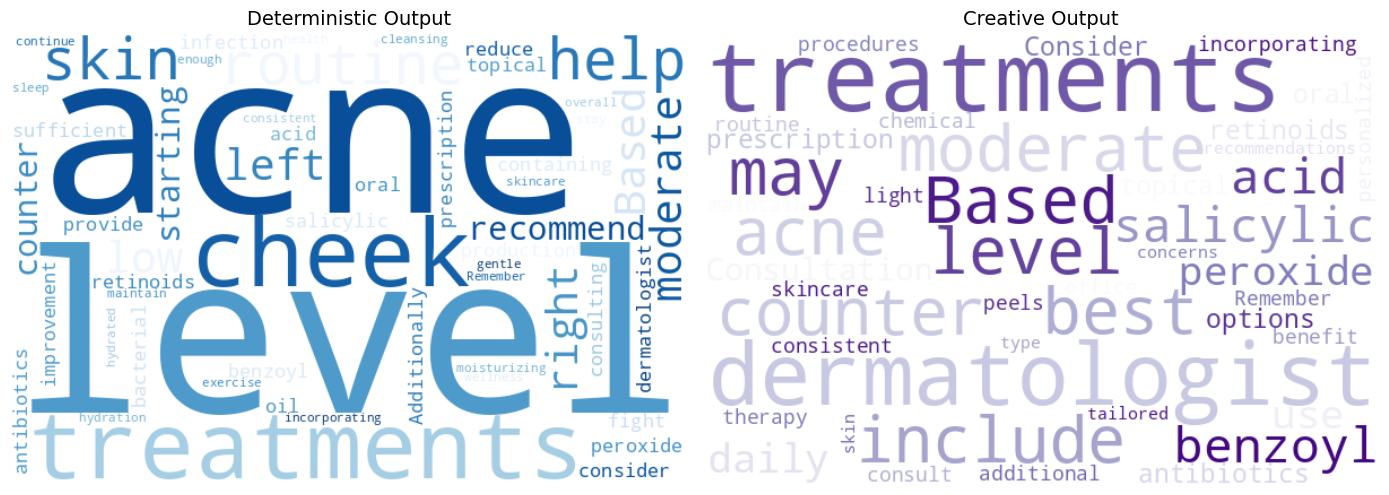

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Texts from LLM responses
text_deterministic = response_deterministic.content
text_creative = response_creative.content

# Create word clouds
wc_deterministic = WordCloud(
    background_color='white',
    width=600,
    height=400,
    colormap='Blues'
).generate(text_deterministic)

wc_creative = WordCloud(
    background_color='white',
    width=600,
    height=400,
    colormap='Purples'
).generate(text_creative)

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].imshow(wc_deterministic, interpolation='bilinear')
axs[0].set_title("Deterministic Output", fontsize=14)
axs[0].axis('off')

axs[1].imshow(wc_creative, interpolation='bilinear')
axs[1].set_title("Creative Output", fontsize=14)
axs[1].axis('off')

plt.tight_layout()
plt.show()

### **✅ Final Model Selection**

After comparing deterministic (`temperature = 0.0`) and creative (`temperature = 0.7`) responses from the LLM, I have decided to proceed with the **deterministic configuration** as the default generation mode.

#### **🔷 Reason for Choosing Deterministic:**
- Provides more **clinically accurate** and **structured** recommendations  
- Maintains a **professional tone** suitable for healthcare-related advice  
- Minimizes unpredictability and keeps answers **consistent across different users**  
- Outputs are slightly longer but contain more actionable information  

#### **🔁 Creative Mode Usage:**
Although the creative version offered more natural and friendly tones, it will be reserved for:
- A/B testing
- Future personalization scenarios
- Optional toggles in user-facing applications (e.g., chatbot tone preferences)